In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
import numpy as np
import string
# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, Flatten
# custom code
from custom_classes.transaction_encoding import *
from custom_classes.utils import *
from custom_classes.custom_keras import *



Using Theano backend.


In [2]:
prefix = 'neuralnet_sample.'


df_transactions = pd.read_csv('transaction_data/query-hive-125642.csv',
                              dtype={prefix + 'acct_id': str,
                                     prefix + 'bookg_amt_nmrc': float,
                                     prefix + 'bookg_cdt_dbt_ind': str,
                                     prefix + 'bookg_dt_tm_cet': str,
                                     prefix + 'ctpty_acct_id_bban' : str,
                                     prefix + 'ctpty_acct_id_iban' : str,
                                     prefix + 'ctpty_adr_line1' : str,
                                     prefix + 'ctpty_adr_line2' : str,
                                     prefix + 'ctpty_nm_accrd_to_bk' : str,
                                     prefix + 'ctpty_nm_accrd_to_orgtr' : str,
                                     prefix + 'dtld_tx_tp' : str,
                                     prefix + 'tx_tp' : str,
                                     prefix + 'lcl_instrm_cd' : str,
                                     prefix + 'rmt_inf_ustrd1' : str,
                                     prefix + 'rmt_inf_ustrd2' : str,
                                     prefix + 'bea' : str,
                                     prefix + 'ruleid' : str,
                                     prefix + 'category' : str,
                                     prefix + 'subcategory' : str}
                             )

df_transactions.columns = ['acct_id',
                           'bookg_amt_nmrc',
                           'bookg_cdt_dbt_ind',
                           'bookg_dt_tm_cet',
                           'ctpty_acct_id_bban',
                           'ctpty_acct_id_iban',
                           'ctpty_adr_line1',
                           'ctpty_adr_line2',
                           'ctpty_nm_accrd_to_bk',
                           'ctpty_nm_accrd_to_orgtr',
                           'dtld_tx_tp',
                           'tx_tp',
                           'lcl_instrm_cd',
                           'rmt_inf_ustrd1',
                           'rmt_inf_ustrd2',
                           'bea',
                           'ruleid',
                           'category',
                           'subcategory']

In [3]:
for column in df_transactions.columns:
    df_transactions.loc[df_transactions[column].isnull(), column] = ''  

In [4]:
df_transactions['category'].unique()

array(['Bankzaken en Verzekeringen', 'Telecom', 'Vrije Tijd',
       'Overige inkomsten', 'Vervoer', 'Huishouden', 'Huis en inrichting',
       'Gezondheid', 'Uitkeringen', 'Wonen en Inrichting',
       'Medische kosten', 'Loon', 'Contributies en abonnementen',
       'Kleding', 'Recreatie en vrije tijd', 'Verzekeringen en geldzaken',
       'Gas, licht en water', 'Heffingen', 'Overige uitgaven', 'Kinderen',
       'Woonlasten', 'Sparen', 'Studiekosten', ''], dtype=object)

gezondheid =?= medische kosten

bankzaken en verzekeringen =?= verzekeringen en geldzaken

recreatie en vrije tijd =?= vrije tijd

wonen en inrichting =?= huis en inrichting


In [5]:
# combine duplicate transactions
df_transactions.loc[df_transactions['category'] == 'Medische kosten', 'category'] = 'Gezondheid'
df_transactions.loc[df_transactions['category'] == 'Bankzaken en Verzekeringen', 'category'] = 'Verzekeringen en geldzaken'
df_transactions.loc[df_transactions['category'] == 'Recreatie en vrije tijd', 'category'] = 'Vrije Tijd'
df_transactions.loc[df_transactions['category'] == 'Huis en inrichting', 'category'] = 'Wonen en Inrichting'

df_transactions['category'].unique()

array(['Verzekeringen en geldzaken', 'Telecom', 'Vrije Tijd',
       'Overige inkomsten', 'Vervoer', 'Huishouden', 'Wonen en Inrichting',
       'Gezondheid', 'Uitkeringen', 'Loon', 'Contributies en abonnementen',
       'Kleding', 'Gas, licht en water', 'Heffingen', 'Overige uitgaven',
       'Kinderen', 'Woonlasten', 'Sparen', 'Studiekosten', ''], dtype=object)

In [6]:
#remove empty labels
#df_transactions = df_transactions.query('category != \'\'')

df_transactions = df_transactions[df_transactions['category'] !='']
#create integer label category
for i, category in enumerate(df_transactions['category'].unique()):
    df_transactions.loc[df_transactions['category'] == category, 'label'] = int(i+1)

In [7]:
#external_dict = '/home/user/160/roularta-160.txt'
#external_dict = '/home/user/large_dict_160/combined-160.txt'
external_dict = None

# create the dictionary based on the availbale transaction data, select specific columns
word_tokenizer = CreateWordTokenizer(df_transactions, ['rmt_inf_ustrd1',
                                                       'rmt_inf_ustrd2',
                                                       'ctpty_nm_accrd_to_orgtr',
                                                       'ctpty_nm_accrd_to_bk',
                                                       'dtld_tx_tp', 
                                                       'tx_tp',
                                                       'lcl_instrm_cd',
                                                       'category',
                                                       'subcategory'
                                                      ], external_dict_path = external_dict)
transaction_converter = TransactionConverter(word_tokenizer)

#included columns to be extracted in sample, the encoding type, and maximum number of words/chars
included_columns = [['bookg_cdt_dbt_ind','word', 1],
                    ['ctpty_acct_id_bban', 'char', 20],
                    ['ctpty_acct_id_iban', 'char', 20],
                    ['ctpty_nm_accrd_to_bk', 'word', 10],
                    ['ctpty_nm_accrd_to_orgtr', 'word', 10],
                    ['dtld_tx_tp', 'word', 1],
                    ['tx_tp', 'word', 1],
                    ['lcl_instrm_cd', 'word', 1],
                    ['rmt_inf_ustrd1', 'word',30],
                    ['rmt_inf_ustrd2', 'word',30],
                    ['category', 'label', 1],
                    ['subcategory', 'label', 1],
                    ['label', 'label', 1]]

79445


In [8]:
# define the model

MAX_SEQUENCE_LENGTH = 84
num_classes = int(max(df_transactions['label']))

model = Sequential()
model.add(Embedding(len(word_tokenizer.tokenizer.word_counts)+1, 22, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(256, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 22)            1747812   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 80, 256)           28416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 256)           327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 256)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 256)           0         
__________

In [9]:
# split data in train/validation/test
datasplit_boundaries = [0.6, 0.7] # [0.6, 0.7] means the first 60% is train,
                                  #the next 10% is validation and the remaining 30 % is test data

    
df_transactions = df_transactions.sample(frac=1).reset_index(drop=True)    
    
split_train = int(datasplit_boundaries[0] * df_transactions.shape[0])
split_validation = int(datasplit_boundaries[1] * df_transactions.shape[0])
    
    
df_transactions_TRAIN, df_transactions_VALIDATION, df_transactions_TEST = np.split(df_transactions,
                                                                                   [split_train,
                                                                                    split_validation],
                                                                                   axis = 0)  

df_transactions_TRAIN = df_transactions #overfit on training data!!!


print 'Amount of training transactions ' + str(df_transactions_TRAIN.shape[0])
print 'Amount of validation transactions ' + str(df_transactions_VALIDATION.shape[0])
print 'Amount of test transactions ' + str(df_transactions_TEST.shape[0])

Amount of training transactions 99987
Amount of validation transactions 9998
Amount of test transactions 29997


In [10]:
transaction_batch_generator_TRAIN = TransactionBatchGenerator(df_transactions_TRAIN,
                                                              transaction_converter,
                                                              included_columns)

transaction_batch_generator_VALIDATION = TransactionBatchGenerator(df_transactions_VALIDATION,
                                                              transaction_converter,
                                                              included_columns)
transaction_batch_generator_TEST = TransactionBatchGenerator(df_transactions_TEST,
                                                              transaction_converter,
                                                              included_columns)


Epoch 0 of 200
Batch 33 of 99
Last accuracy on validation set: 0.0278064131737
Best accuracy on validation set: 0.0278064131737


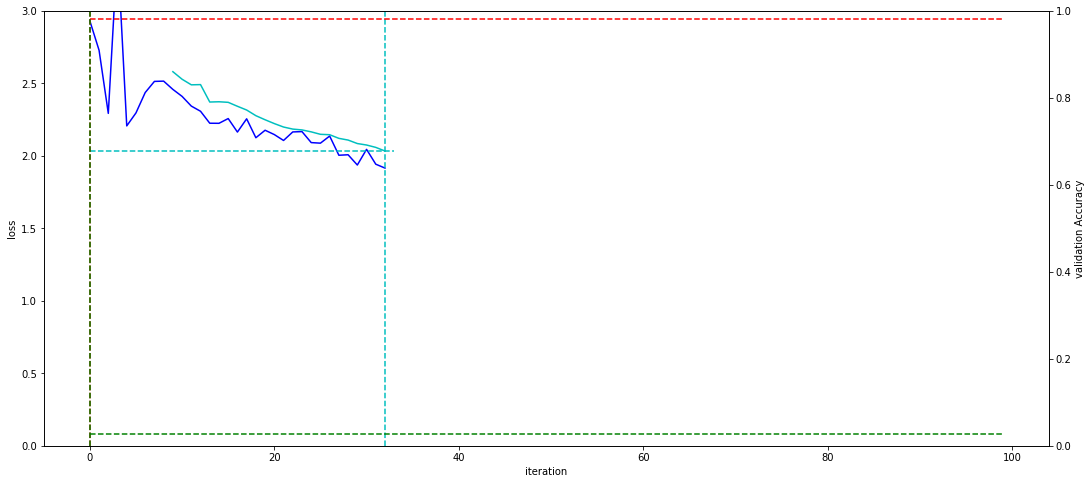

In [ ]:
NUM_EPOCHS = 200
BATCH_SIZE = 1000

plt.rcParams['figure.figsize'] = (18, 8)

val_accuracy_total = []
val_loss_total = []
train_loss_total = []

for j, epoch in enumerate(range(NUM_EPOCHS)):
    # create generation objects
    
    transaction_batch_generator_TRAIN.shuffle_data()
    
    training_batches = transaction_batch_generator_TRAIN.get_transactions_as_generator_object(BATCH_SIZE)
    validation_batches = transaction_batch_generator_VALIDATION.get_transactions_as_generator_object(BATCH_SIZE)
    
    
    loss_accum = []
    accuracy_accum = []
    for batch in validation_batches:
        X = np.concatenate([batch['ctpty_nm_accrd_to_orgtr'],
                            batch['ctpty_nm_accrd_to_bk'], 
                            batch['dtld_tx_tp'],
                            batch['tx_tp'],
                            batch['lcl_instrm_cd'],
                            batch['bookg_cdt_dbt_ind'],
                            batch['rmt_inf_ustrd1'],
                            batch['rmt_inf_ustrd2']], axis = 1)
        y = convert_to_onehot(batch['label'], num_classes)
        
        loss, acc = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
        loss_accum.append(loss)
        accuracy_accum.append(acc)
    val_loss_total.append(np.mean(loss_accum))
    val_accuracy_total.append(mean(accuracy_accum))


    for i, batch in enumerate(training_batches): 
        clear_output()
        print "Epoch " + str(j) + " of " + str(NUM_EPOCHS)
        print "Batch " + str(i) + " of " + str(transaction_batch_generator_TRAIN.num_batches)
        print "Last accuracy on validation set: " + str(val_accuracy_total[-1])
        print "Best accuracy on validation set: " + str(np.max(val_accuracy_total))
        plot_learning_curve(train_loss_total,
                            val_loss_total,
                            val_accuracy_total,
                            transaction_batch_generator_TRAIN.num_batches)
        
        X = np.concatenate([batch['ctpty_nm_accrd_to_orgtr'],
                            batch['ctpty_nm_accrd_to_bk'], 
                            batch['dtld_tx_tp'],
                            batch['tx_tp'],
                            batch['lcl_instrm_cd'],
                            batch['bookg_cdt_dbt_ind'],
                            batch['rmt_inf_ustrd1'],
                            batch['rmt_inf_ustrd2']], axis = 1)
        y = convert_to_onehot(batch['label'], num_classes)
        
        
        loss, acc = model.train_on_batch(X, y)
        train_loss_total.append(loss)

In [ ]:
loss_total = []
acc_total = []

test_batches = transaction_batch_generator_TEST.get_transactions_as_generator_object(BATCH_SIZE)

for batch in test_batches:
    X = np.concatenate([batch['ctpty_nm_accrd_to_orgtr'],
                        batch['ctpty_nm_accrd_to_bk'],
                        batch['dtld_tx_tp'],
                        batch['tx_tp'],
                        batch['lcl_instrm_cd'],
                        batch['bookg_cdt_dbt_ind'],
                        batch['rmt_inf_ustrd1'],
                        batch['rmt_inf_ustrd2']], axis = 1)
    y = convert_to_onehot(batch['label'], num_classes)

    loss, acc = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
    loss_total.append(loss)
    acc_total.append(acc)
print np.mean(loss_total)
print np.mean(acc_total)


In [ ]:
for i,[l,c] in enumerate(zip(df_transactions['label'].unique(), df_transactions['category'].unique())):
    print l,c
    